## Task 2: Build a SURROGATE MODEL using GENERATIVE AI

#### 1) Import Dependencies

In [14]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


In [4]:
%load_ext autoreload
%autoreload 2

In [15]:
from vae import DataPreparation, WildFireDataset
from vae import VAE
from vae import train_vae, loss_function, grid_search, evaluate_vae_results
from vae import generate_images_iteratively, reshape_sequence_data_for_plots, generate_random_outputs

#### 2) Initialise Datasets to Train Model

In [7]:
DataPreparator = DataPreparation(train_path="../data/Ferguson_fire_train.npy", test_path="../data/Ferguson_fire_test.npy")
wildfires_training_set, wildfires_testing_set = DataPreparator.separate_and_filter_datas()

train_dataset = WildFireDataset(wildfires_training_set, n_previous=1, skipped_frame=10)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### 3) Initialise VAE Architecture 

In [10]:
vae = VAE('cuda', 65536, [256, 128], 32, activation="GELU")
#aec = VAE.VAE('cuda', 65536, [256, 128], 32, activation="GELU")
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)


#### 4) Train VAE on Training DataLoader

In [ ]:
#aec, _ = train_vae(aec, train_loader, optimizer, epochs=100)

In [12]:
# autoencoder_path = "../vae_state_assessment.pth"
autoencoder_path = "test_checkpoint_best_vae.pth" #change path to final model
state_dict = torch.load(autoencoder_path)['model_state_dict']
# torch.save(state_dict,'best_vae_state_dict.pth')
vae.load_state_dict(state_dict)
state_dict_path = 'best_vae_state_dict.pth'

#### 5) Initialise Datasets to Test Model

In [16]:
test_dataset = WildFireDataset(wildfires_testing_set, n_previous=1, skipped_frame=10, flatten=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 6) Evaluate VAE Performance on Test Dataset

In [17]:
res_test = evaluate_vae_results(vae, state_dict_path, test_dataset, 32)
res_test_2D = np.reshape(res_test, (np.shape(res_test)[0], np.shape(res_test[0])[0], 256, 256))

## Step 2
### Generate wildfire samples using only the decoder and random latent space

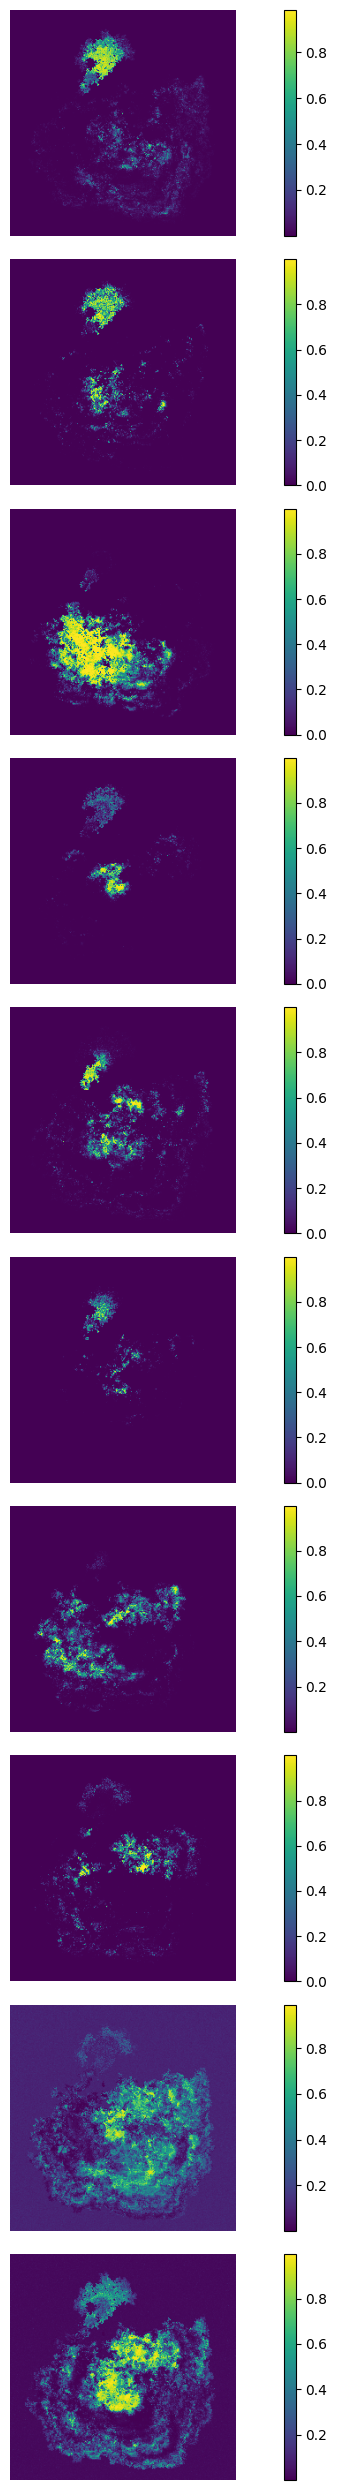

In [22]:
n = 10
random_outputs = generate_random_outputs(vae, n, 32, 'cpu')
random_outputs = np.reshape(np.array(random_outputs), (n, 256, 256))
 
fig, axs = plt.subplots(10, figsize=(10, 25))
vmin = 0
vmax = 1
 
# Loop through each pair of images and display them
for i in range(10):
    im1 = axs[i].imshow(random_outputs[i])
    axs[i].axis('off')  # Hide the axis
    fig.colorbar(im1, ax=axs[i])
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Step 3
### Compare results with fire_obs

#### 7) Initialise and reshape background and observational data 

In [20]:
fire_background = reshape_sequence_data_for_plots('../data/Ferguson_fire_background.npy')
fire_obs = reshape_sequence_data_for_plots('../data/Ferguson_fire_obs.npy')

In [21]:
initial_image = torch.tensor(fire_obs[0].astype('float32')).to(device)
generated_images = np.array(generate_images_iteratively(vae, initial_image, num_iterations=10))

#### 8) Visualise Outputs

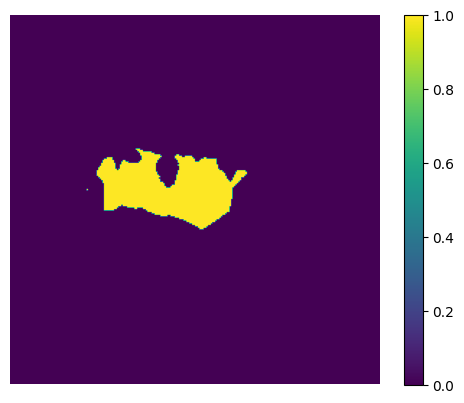

In [22]:
fig, axs = plt.subplots(1)
im1 = axs.imshow(np.reshape(initial_image.cpu().numpy(), (1, 256, 256))[0])
axs.axis('off')  # Hide the axis
fig.colorbar(im1, ax=axs)

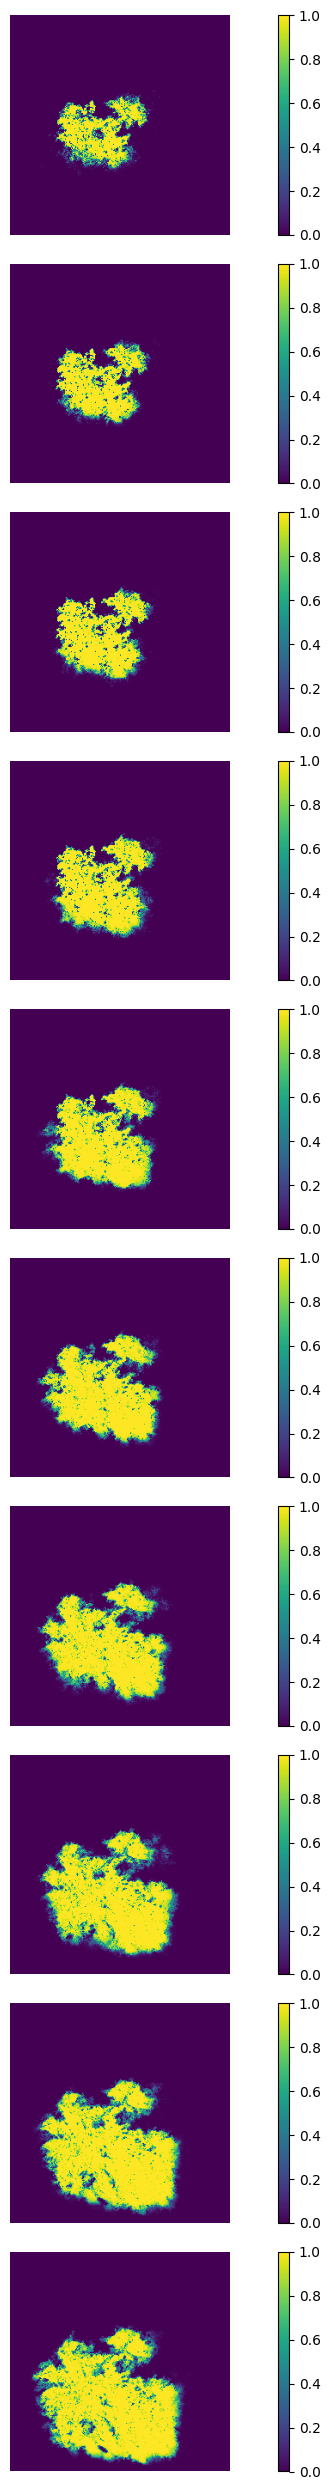

In [23]:
fig, axs = plt.subplots(10, figsize=(10, 25))
vmin = generated_images[0].min()
vmax = generated_images[0].max()

# Loop through each pair of images and display them
for i in range(10):
    im1 = axs[i].imshow(generated_images[i][0])
    axs[i].axis('off')  # Hide the axis
    fig.colorbar(im1, ax=axs[i])
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()